In [265]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [266]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [267]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [268]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [269]:
# # Declare a Base using 'automap_base()'
Base = automap_base()
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)
# reflect the tables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [270]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [271]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [272]:
# Create our session (link) from Python to the DB
session = Session(engine)
results_meas = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).order_by(Measurement.date.desc()).all()
results_stat = session.query(Station.station, Station.name, Station.latitude , Station.longitude, Station.elevation).all()

## Bonus Challenge Assignment: Temperature Analysis II

In [273]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [274]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
temp_data = (calc_temps('2017-08-01', '2017-08-07'))
temp_min = temp_data[0][0]
temp_avg = round(temp_data[0][1],2)
temp_max = temp_data[0][2]

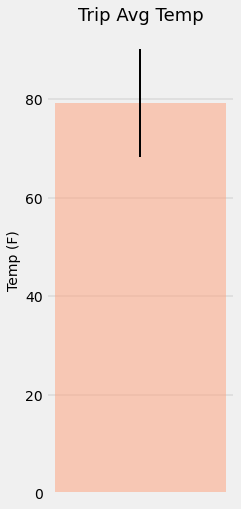

In [275]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerror = temp_max - temp_min
plt.subplots(figsize=(3, 8))
plt.errorbar(0,temp_avg, yerr=yerror, fmt=" ", ecolor="black", elinewidth=2)
plt.bar(0,temp_avg, width=0.1, color="lightsalmon", alpha=0.5)
plt.ylabel('Temp (F)',fontsize=14)
plt.ylim = (0,100)
plt.grid(axis='y',color='grey', linestyle='-', linewidth=0.3)
plt.title('Trip Avg Temp',fontsize=18)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.savefig("Output/Temp_yerror.png")
plt.show()

### Daily Rainfall Average

In [276]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
meas_df=pd.DataFrame(results_meas)
stat_df=pd.DataFrame(results_stat)
df=pd.merge(meas_df,stat_df,on='station',how='inner')
df_trip = df.loc[(df['date']>='2017-08-01') & (df['date']<='2017-08-07')]
station_df = df_trip.groupby('station')
rainfall_df = station_df['prcp'].sum()

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#rainfall_df.sort_values('prcp',ascending=False)
df=pd.merge(rainfall_df,df_trip,on='station',how='outer')

# Drop unwated columns
df_clean = df.drop(['prcp_y','tobs','prcp_y','date'], axis=1)

# Rename column with the total rainfall per station
df_clean = df_clean.rename(columns={'prcp_x': 'total prcp'})

# Find the duplicated rows with same total rainfall per station
duplicate_df=df_clean.duplicated(subset=['total prcp'])

# Adds duplicated column to dataframe
df_clean['Duplicated']=duplicate_df.values

# Remove all rows that contains duplicated values and keeps only one value of each
df_final = df_clean.drop_duplicates(subset='total prcp', keep="first")
df_final = df_final.sort_values('total prcp',ascending=False)
df_final = df_final.drop(['Duplicated'], axis=1)
print(df_final )

        station  total prcp                                    name  latitude  \
6   USC00516128        0.36            MANOA LYON ARBO 785.2, HI US  21.33310   
0   USC00514830        0.22  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130   
12  USC00519281        0.06                     WAIHEE 837.5, HI US  21.45167   
15  USC00519397        0.04                    WAIKIKI 717.2, HI US  21.27160   
22  USC00519523        0.00      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556   

    longitude  elevation  
6  -157.80250      152.4  
0  -157.83740        7.0  
12 -157.84889       32.9  
15 -157.81680        3.0  
22 -157.71139       19.5  


In [277]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [278]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'


# Use the start and end date to create a range of dates
df_trip = df.loc[(df['date']>=start_date) & (df['date']<=end_date)]
df_range = pd.to_datetime(df_trip['date'], format='%Y-%m-%d')

# Strip off the year and save a list of strings in the format %m-%d
df_range= df_range.dt.strftime('%m-%d')
# convert series to a list
trip_dates=df_range.tolist()

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for date in trip_dates:
    normals.append(daily_normals(date))

In [313]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals)
min_list = []
avg_list = []
max_list = []
c=0
for x in normals_df.iterrows():
    min_list.append(normals_df[0][c][0])
    avg_list.append(normals_df[0][c][1])
    max_list.append(normals_df[0][c][2])
    c=c+1
    
min_df = pd.DataFrame(min_list)
min_df = min_df.rename(columns={min_df.columns[0]:'min_temp'})
avg_df = pd.DataFrame(avg_list)
avg_df = avg_df.rename(columns={avg_df.columns[0]:'avg_temp'})
max_df = pd.DataFrame(max_list)
max_df = max_df.rename(columns={max_df.columns[0]:'max_temp'})
df = pd.concat([df_range, min_df], axis=1)
df = pd.concat([df, avg_df], axis=1)
df = pd.concat([df, max_df], axis=1)
df = df.set_index('date')

df_grouped = df.groupby('date')
df_grouped_min = df_grouped['min_temp'].mean()
df_grouped_avg = df_grouped['avg_temp'].mean()
df_grouped_max = df_grouped['max_temp'].mean()

print(df_grouped_max)

date
08-01    83.0
08-02    84.0
08-03    85.0
08-04    84.0
08-05    82.0
08-06    83.0
08-07    83.0
Name: max_temp, dtype: float64


       min_temp   avg_temp  max_temp
date                                
08-01      67.0  75.540000      83.0
08-02      68.0  75.603774      84.0
08-03      70.0  76.611111      85.0
08-04      69.0  76.711538      84.0
08-05      69.0  76.148148      82.0
08-06      67.0  76.250000      83.0
08-07      71.0  77.156863      83.0


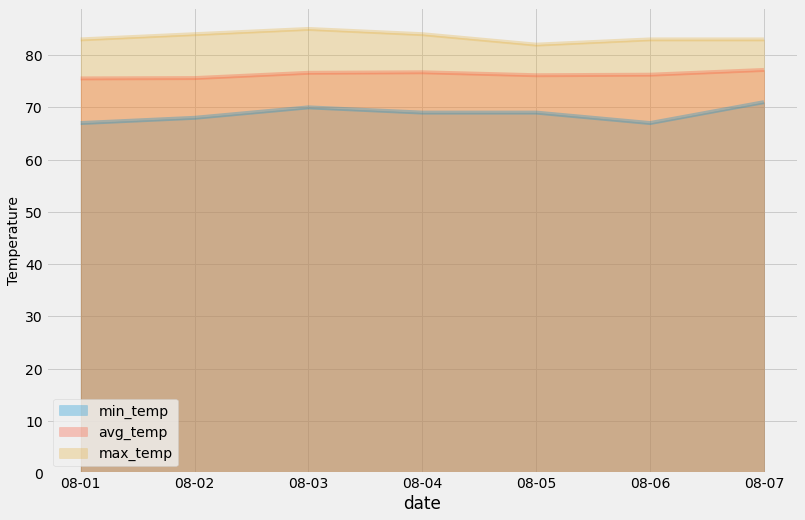

In [333]:
# Plot the daily normals as an area plot with `stacked=False`
df_final = pd.concat([df_grouped_min,df_grouped_avg], axis=1)
df_final = pd.concat([df_final,df_grouped_max], axis=1)
x=df_final.index
y1=df_final['min_temp']
y2=df_final['avg_temp']
y3=df_final['max_temp']
print(df_final)
ax = df_final.plot.area(stacked=False, figsize=(12,8), alpha=0.3)
ax.set_ylabel('Temperature',fontsize=14)
plt.savefig("Output/normals.png")
plt.show()

## Close Session

In [33]:
session.close()